# Demo: Chirp mass distribution of binary black holes (BBHs)

This notebook reproduces Figure 10 of the COMPAS Paper (_arXiv_: ; Riley et al., in prep.) The data can be reproduced by running the attached `stroopwafel_interface.py`, that reads in the `pythonSubmit.py`

This file contains the output of 10,000,000 binaries evolved using COMPAS v02.19.04, using adaptive importance sampling , sampling from a metallicity uniform in $\log(Z) \in [10^{-4},0.03]$. More details can be found in `Run_Details.txt`.

The rates were calculated by running ```FastCosmicIntegration.py```  from COMPAS's post-processing tools, with the following flags altered from their default values:


```:::bash
    python FastCosmicIntegration.py  --path /n/de_mink_lab/Users/lvanson/CompasOutput/v02.19.04/N1e7_Fid/fWR1.0coolWind1.0//output/ --filename COMPAS_Output_wWeights.h5 --mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 --weight mixture_weight --zstep 0.01 --sens O1 --m1min 10. --aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7 > $OUT_DIR/masterfolder/CosmicIntegration/COMPAS_CI1.log 
```


For a more detailed explanation of the workings of COMPAS's post-processing tools, please work through the Jupyter Notebook tutorials in the `postProcessing` directory.

## Paths and libraries
* If you would like to use this script for your own COMPAS Output, you can change `fileName`.

In [11]:
import numpy as np
import h5py as h5
from astropy.table import Table, Column

import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
from matplotlib import ticker, cm

from scipy import stats


######################################
fileName    = '/Volumes/TOSHIBA_EXT/CompasOutput/v02.19.04/N1e7_Fid/fWR1.0coolWind1.0/output/COMPAS_Output_wWeights.h5'#_forCOMPASmethod/'#/N1e7_Fid/'


######################################
##PLOT setttings
plt.rc('font', family='serif')

from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




# Read your data

In [17]:
 ################################################
## Open hdf5 file
File        = h5.File(fileName ,'r')

# The group that contains the rate data
rate_key = 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0_zBinned'
################################################
## Read merger rate related data
DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
redshifts                 = File[rate_key]['redshifts'][()] # Redshifts at which the rates were calculated
# O1_detection_rate         = File[rate_key]['detection_rateO1'][()] # detection rate for O1 sensitivity 
intrinsic_rate_density    = File[rate_key]['merger_rate'][()]  # Intrinsic BBH merger rate density


# Read the DCO masses, Select only merging BBHs
Mass1              = File['DoubleCompactObjects']['Mass(1)'][DCO_mask]
Mass2              = File['DoubleCompactObjects']['Mass(2)'][DCO_mask]
M_moreMassive      = np.maximum(Mass1, Mass2)
M_lessMassive      = np.minimum(Mass1, Mass2)


File.close()

# Set values

In [22]:
######################################
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
# Calculate the chrip mass
Mchirp = Mchirp(M_moreMassive, M_lessMassive)

# Use the detection rates at O1 sensitivity
ratePerSys_observed = np.sum(intrinsic_rate_density, axis=1)
mask = Mchirp < 100 # Set maximum plotted chirp mass to be 100 Msun

# Set grid in chirp mass
binsMchirp  = np.linspace(0, 40, 20)
binwidth    = np.diff(binsMchirp)
center_bins = (binsMchirp[1:] + binsMchirp[:-1]) / 2.0

# yvalues, _ = np.histogram(Mchirp[mask], bins=binsMchirp, weights=ratePerSys_observed[mask])
# dydMchirp = np.divide(yvalues, dMchirp)

#################################
# The data that you will plot
x_vals  = Mchirp
Weights = ratePerSys_observed
Bins    = binsMchirp

#################################
# Would you like to bootstrap your data?
# Warning, this is slow
bootstrap  = True
bootstraps =  10

#################################
# What colour should your plot be
colors  = 'grey'

boostrap b= 0
boostrap b= 1
boostrap b= 2
boostrap b= 3
boostrap b= 4
boostrap b= 5
boostrap b= 6
boostrap b= 7
boostrap b= 8
boostrap b= 9


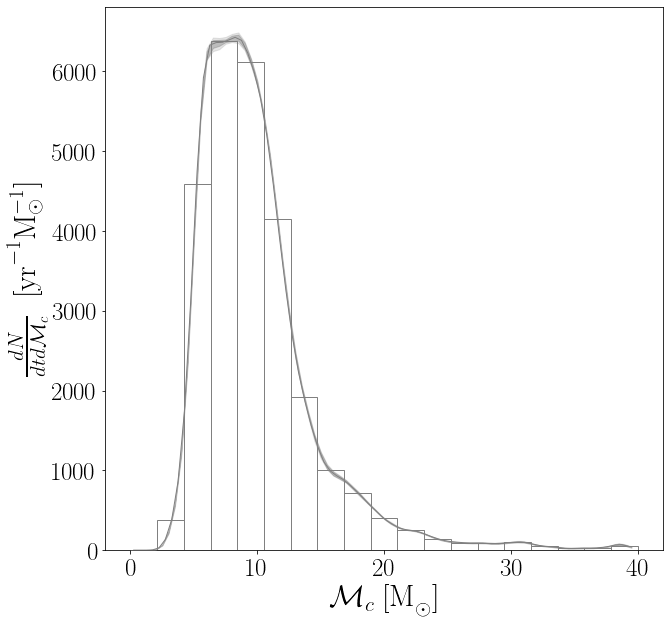

In [34]:
#########################################
# Start plotting
fig, ax = plt.subplots(figsize = (10,10))


########################
# Plot the Histogram   
hist, bin_edge = np.histogram(x_vals, weights = Weights, bins = Bins)
ax.bar(center_bins, hist/binwidth, width= binwidth,alpha=1.,  color='white', 
       fill=False, edgecolor=colors,lw = 1.) 

########################
# Add the KDE
kernel = stats.gaussian_kde(x_vals, bw_method=0.1, weights=Weights)
# plot the KDE at these x-ticks
x_KDE = np.arange(0,40,0.5) 
center_KDEbins = (x_KDE[:-1] + x_KDE[1:])/2.
# Re-normalise the KDE
y_vals = kernel(center_KDEbins)*sum(hist)

# Plot it and fill the area underneath the curve :)
ax.plot(center_KDEbins, y_vals, lw=1, color=colors)

########################
# Bootstrap to obtain sampling errors
if bootstrap:
    indices = np.arange(len(x_vals))
    hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
    for b in range(len(hist_vals)):
        print('boostrap b=', b)
        boot_index = np.random.choice(indices, size=len(indices), replace=True)

        kernel       = stats.gaussian_kde(x_vals[boot_index], bw_method=0.1, weights=Weights[boot_index])
        Hist, _      = np.histogram(x_vals[boot_index], bins=Bins,weights=Weights[boot_index],density=False)

        hist_vals[b] = kernel(x_KDE)*sum(Hist)

    # calculate 1- and 2- sigma percentiles
    percentiles = np.percentile(hist_vals, [15.89, 84.1, 2.27, 97.725], axis=0)
    median = np.percentile(hist_vals, [50], axis=0)
    
    ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=colors, zorder = 11) # 1-sigma
    ax.fill_between(x_KDE, percentiles[2], percentiles[3],alpha=0.2, color=colors, zorder = 10) # 2-sgima    

    
#########################################
# plot values
ax.set_xlim(0,40)
# ax.set_ylim(1e-2,1)

ax.set_xlabel('$\mathcal{M}_c \ \mathrm{[M}_{\odot} \mathrm{]}$', fontsize = 30)
ax.set_ylabel('$\\frac{dN}{dt d\mathcal{M}_{c}}$ \ $\mathrm{[yr}^{-1}\mathrm{M}_{\odot}^{-1}\mathrm{]}$', fontsize = 30)

# plt.savefig(save_loc+'/'+x_key+'O1detection_.pdf', bbox_inches='tight')

plt.show()





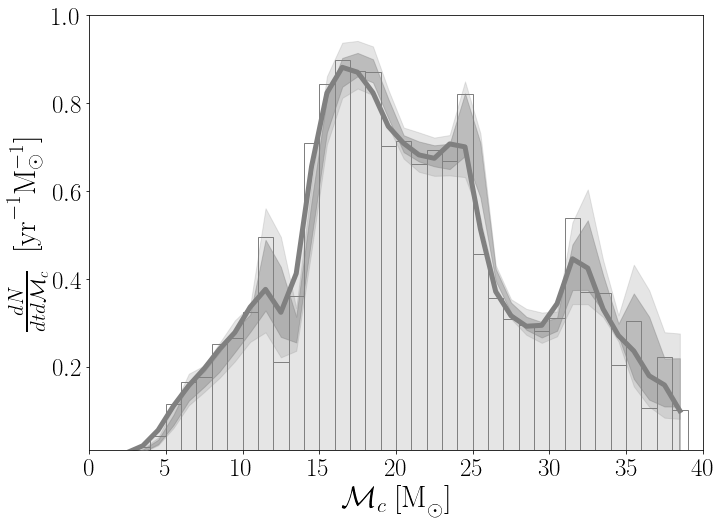

In [20]:
# Use O1 sensitivity
ratePerSys_observed = np.sum(W_io1, axis=1)
# dN/(da)
plot_dist(merging_BBH, 'Mchirp', ratePerSys_observed, SW=True,
          xlabel = "$\mathcal{M}_c \ \mathrm{[M}_{\odot} \mathrm{]}$", kde_width = 0.1, 
          ylabel='$\\frac{dN}{dt d\mathcal{M}_{c}}$ \ $\mathrm{[yr}^{-1}\mathrm{M}_{\odot}^{-1}\mathrm{]}$',
          logx = False, logy=False, fill =True, show_hist=True, show_KDE=True,
          x_lim=(0,40),y_lim=(1e-2,1), bootstrap=True, bootstraps = 50,
          bins = np.arange(0,40,1.), x_KDE = np.arange(0,40,1.),
          save_plot=True)






In [2]:
CI = ClassCosmicIntegrator.CosmicIntegrator(pathCOMPAS=pathData, fileName=fileName)

reminders of what to set in the following order:

ClassCOMPAS: Remember to self.setGridAndMassEvolved() [optional]
                   then  self.setCOMPASDCOmask()
                   then  self.setCOMPASData()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassCosmicIntegrator: Remember to setBirthTimesAnd2Darrays()
                        to prepare calculation/results
                        do you have the GW-detector you want?


## Set the COMPAS class in our cosmicIntegrator

In [3]:
# Set lower and upper mass limits used for Kroupa IMF when drawing ZAMS stars in the COMPAS run
CI.COMPAS.Mlower = 5.0
CI.COMPAS.Mupper = 150.0

CI.COMPAS.binaryFraction = 0.7

CI.COMPAS.setGridAndMassEvolved()
CI.COMPAS.setCOMPASDCOmask()  # By default, this masks for BBHs formed under the pessimistic CE assumption
CI.COMPAS.setCOMPASData()  # This carries out the mask

## Specify the MSSFR model

In [5]:
CI.MSSFR.SFRprescription = "Neijssel et al. (2019)"
CI.MSSFR.Zprescription = "logNormal"
CI.MSSFR.logNormalPrescription = "Neijssel Phenomenological"

# Set the metallicity grid from the COMPAS output
CI.MSSFR.metallicityGrid = CI.COMPAS.metallicityGrid
CI.MSSFR.calculateMetallicityBinEdges()
CI.setBirthTimesAnd2Darrays() 

## Perform the cosmic integration

In [6]:
CI.cosmologicalIntegration()

## Create chirp mass distribution

In [10]:
chirpMass = CI.COMPAS.mChirp
ratePerSys_observed = np.sum(CI.PerSystemPerRedshift_ratesObserved, axis=0)
mask = chirpMass < 100 # Set maximum plotted chirp mass to be 100 Msun

# Set grid in chirp mass
binsMchirp = np.linspace(0, 40, 20)
dMchirp = np.diff(binsMchirp)
center = (binsMchirp[1:] + binsMchirp[:-1]) / 2.0

yvalues, _ = np.histogram(chirpMass[mask], bins=binsMchirp, weights=ratePerSys_observed[mask])
dydMchirp = np.divide(yvalues, dMchirp)

## Plot chirp mass distribution

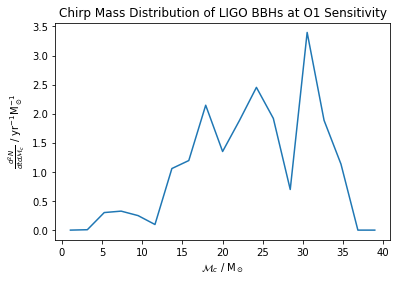

In [11]:
fig, axes = plt.subplots(1, 1)
axes.plot(center, dydMchirp)
plt.title("Chirp Mass Distribution of LIGO BBHs at O1 Sensitivity")
axes.set_xlabel("$\mathcal{M}_c}$ / $\mathrm{M}_\odot$")
axes.set_ylabel("$\\frac{d^2N}{dtd\mathcal{M}_c}$ / $\mathrm{yr}^{-1}\mathrm{M}_\odot^{-1}$")
plt.show()

In [1]:

def plot_dist(table, x_key, WEIGHTS, xlabel,
              bins = np.arange(0,50,2), kde_width = 0.1, 
              x_KDE = np.arange(0.,50.,2),
              bootstrap  = False, bootstraps = 100, FIGSIZE=(11, 8),
              logx = False, logy=False, x_lim=(0,50), y_lim=None, save_plot=False,
              fill = True, All = True, show_hist = True, show_KDE = True, SW = True,
              ylabel=r'$R_{\mathrm{BBH} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$',
              colors = ['grey' ,'#73bdb3',  '#e388b0']):
    """
    Function to plot the weighted disrtibution for the stable RLOF and the CE channel seperately
    
    table         -------> [astropy table] the table that you would like to plot
    x_key         -------> [str] what key in table to plot the distribution of
    WEIGHTS       -------> [array] list of weights (usually the rate) to weigh dist. (same len as table)
    
    SW            -------> [bool] if true, use 'mixture_weight' = stroopwafel as weight
    redshift_list -------> [array] if WEIGHTS represent Rates you need redshift to convert too detector frame
    fill          -------> [bool] fill the plt.plot with a light shade
    All           -------> [bool] Add a line for the total dist
    bins          -------> [array] how to bin your x_key
    kde_width     -------> [float] bw metthod of KDE
    logx          -------> [bool] if you want the y-scale in log
    logy           -------> [bool] if you want log10(x), make sure to adjust bins!
    x_lim         -------> [min,max] x lim of plot
    xlabel        -------> [str] x axis label
    colors        -------> [array] 2 colours representing [CE, stable RLOF]
    save_plot     -------> [bool] save plot or not
    """

    # Bools and labels to split by stable RLOF vs CE channel
    Bool_list = [np.full(len(table), True), table['CE_Event_Count'] > 0, table['CE_Event_Count'] == 0 ]
#     labels     = ['$\mathrm{All \ BBHs}$', '$\mathrm{CE \ channels}$', '$\mathrm{Stable \ RLOF \ channel}$']
    labels     = ['$\mathrm{Neijssel Phenom.}$', '$\mathrm{CE \ channels}$', '$\mathrm{Stable \ RLOF \ channel}$']

    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = FIGSIZE)

    hatches = ['', '/', 'x', 'o' ]

    for i, Bool in enumerate(Bool_list):
#         if i == 0:
#             if not All:
#                 continue
#             Fill, Show_hist = False, False
#         else:
        if i > 0:
            continue
        Fill, Show_hist = fill, show_hist
        ########################
        # X and weight values
        if SW:
            m_Weight     = WEIGHTS[Bool]#table['mixture_weight'][Bool]
        else:
            m_Weight     = np.sum(WEIGHTS[Bool,:]/(1+center_z), axis = 1) 

        x_vals = table[x_key][Bool]        
        if logx: # Assuming you've provided bin in logx!
            # Change of variables
            x_vals = np.log10(x_vals)
            
            # Set the ticks in non log format for readibility
            x_pow = np.arange(x_lim[0], x_lim[-1], 1.)
            plt.xticks(x_pow, ['$%s$'%(x) for x in 10**x_pow])
#         else:
#             ax.set_xscale('log')
                
        
        ########################
        # Plot the Hist    
        hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
        center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
        binwidth = np.diff(bins)
        #print('center_bins',center_bins, 'binwidth', binwidth)
        if Show_hist:
            ax.bar(center_bins, hist/binwidth, width= binwidth, #
                   alpha=1.,  color='white', fill=True, edgecolor=colors[i],
                   lw = 1., zorder = i, hatch = hatches[i]) 
        
        ########################
        # Add the KDE
        if show_KDE:
            kernel = stats.gaussian_kde(x_vals, bw_method=kde_width, weights=m_Weight)
            #center_bins#
            center_KDEbins = (x_KDE[:-1] + x_KDE[1:])/2.
            y_vals = kernel(center_KDEbins)*sum(hist)#/binwidth) * (np.diff(x_KDE))#re-normalize the KDE
            ax.plot(center_KDEbins, y_vals, lw=5, color=colors[i], zorder = i+1,label = labels[i])
            if Fill:
                ax.fill_between(center_KDEbins,y1=0, y2=y_vals, color=colors[i], zorder = i+2, alpha = 0.2)
                ax.fill_between(center_KDEbins,y1=0, y2=y_vals, facecolor="none", edgecolor=colors[i],zorder = i+3, hatch = hatches[i])


        ########################
        # Bootstrap        
        if bootstrap:
            indices = np.arange(len(x_vals))
            hist_vals = np.zeros((bootstraps, len(center_bins)))
            #print('len(hist_vals)',len(hist_vals))
            for b in range(len(hist_vals)):

                boot_index = np.random.choice(indices, size=len(indices), replace=True)

                hist_vals[b], _ = np.histogram(x_vals[boot_index], bins=bins,
                                               weights=m_Weight[boot_index],density=False)

            # calculate 1- and 2- sigma percentiles
            percentiles = np.percentile(hist_vals, [15.89, 84.1, 2.27, 97.725], axis=0)
            
            # Trying to smoothen stuff
            smooth_num = 2
            def smooth(y, box_pts):
                box = np.ones(box_pts)/box_pts
                y_smooth = np.convolve(y, box, mode='same')
                return y_smooth
            
            # plot uncertainties as filled areas
            ax.fill_between(center_bins, smooth(percentiles[0],smooth_num)/binwidth,smooth(percentiles[1],smooth_num)/binwidth, 
                            alpha=0.4, color=colors[i], zorder = 11) # 1-sigma
            ax.fill_between(center_bins, smooth(percentiles[2],smooth_num)/binwidth, smooth(percentiles[3],smooth_num)/binwidth,
                            alpha=0.2, color=colors[i], zorder = 10) # 2-sgima

        
    #########################################
    # plot values
    if x_lim != None:
        ax.set_xlim(x_lim)
    if y_lim != None:
        ax.set_ylim(y_lim)
#     leg = ax.legend(fontsize = 20)

    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    
    if logy:
        ax.set_yscale('log')

    if save_plot:
        plt.savefig(save_loc+'/'+x_key+'O1detection_.pdf', bbox_inches='tight')

    plt.show()

    
    




    

NameError: name 'np' is not defined

In [ ]:
# Use O1 sensitivity
ratePerSys_observed = np.sum(W_io1, axis=1)
# dN/(da)
plot_dist(merging_BBH, 'Mchirp', ratePerSys_observed, SW=True,
          xlabel = "$\mathcal{M}_c \ \mathrm{[M}_{\odot} \mathrm{]}$", kde_width = 0.1, 
          ylabel='$\\frac{dN}{dt d\mathcal{M}_{c}}$ \ $\mathrm{[yr}^{-1}\mathrm{M}_{\odot}^{-1}\mathrm{]}$',
          logx = False, logy=False, fill =True, show_hist=True, show_KDE=True,
          x_lim=(0,40),y_lim=(1e-2,1), bootstrap=True, bootstraps = 50,
          bins = np.arange(0,40,1.), x_KDE = np.arange(0,40,1.),
          save_plot=True)




